In [1]:
import numpy
import os
import re
import binascii
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_csv('data/cleaned_data.csv')

In [3]:
df

,Unnamed: 0,timestamp,module,code,message
0,0,1613190301,libloggingstdlog,none,"[origin software=""rsyslogd"" swVersion=""8.24.0""..."
1,1,1613193421,CRON,32398,(root) CMD ( cd / && run-parts --report /etc/c...
2,2,1613197021,CRON,6546,(root) CMD ( cd / && run-parts --report /etc/c...
3,3,1613200621,CRON,12800,(root) CMD ( cd / && run-parts --report /etc/c...
4,4,1613204221,CRON,19277,(root) CMD ( cd / && run-parts --report /etc/c...
...,...,...,...,...,...
3276,3276,1613708134,systemd,1,Started Daily apt upgrade and clean activities.
3277,3277,1613708134,systemd,1,apt-daily-upgrade.timer: Adding 53min 41.15131...
3278,3278,1613708134,systemd,1,apt-daily-upgrade.timer: Adding 58min 49.84154...
3279,3279,1613708221,CRON,8266,(root) CMD ( cd / && run-parts --report /etc/c...


In [4]:
msgs_list =[] 
  
# Iterate over each row 
for index, rows in df.iterrows(): 
    # Create list for the current row 
    message =[rows.message] 
      
    # append the list to the final list 
    msgs_list.extend(message) 
  
# Print the list 
print(len(msgs_list)) 

3281


In [5]:
duplicate_dict = Counter(msgs_list)
print(len(duplicate_dict))

802


In [6]:
unique = list(set(df.message))

In [7]:
len(unique)

802

In [8]:
def get_shingles(msg, k=10):
    """Get all shingles from requested file (hashes of these shingles)
    """
    L = len(msg)
    shingles = set()  # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):
        shingle = msg[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8')) #& 0xffffffff  # hash the shingle to a 32-bit integer
        shingles.add(crc)
    return shingles

In [9]:
k = 5
print(msgs_list[0]) 
print(" ")
print(get_shingles(msgs_list[0],k=k))
print(len(get_shingles(msgs_list[0],k=k)))

[origin software="rsyslogd" swVersion="8.24.0" x-pid="314" x-info="http://www.rsyslog.com"] rsyslogd was HUPed
 
{1343353859, 3431262724, 3796937221, 1474564, 1005765643, 1756066317, 2676634638, 4157158927, 3025636371, 2807985688, 3064696857, 2080374811, 2055046688, 1223483937, 2327031337, 1792651822, 1326109240, 2811462718, 1416381521, 869498968, 3078835292, 413350495, 433927273, 1803644527, 1496130162, 4158404220, 747965567, 1432094339, 3623413382, 838245522, 3964478110, 172811937, 3044958381, 3661133497, 4277061307, 2478284476, 1043704510, 3051292359, 3693939914, 2308058831, 1074276567, 364835555, 1624029414, 2142170874, 830371068, 3585689343, 465479936, 991218438, 3158399243, 4011242252, 2819367188, 1822101270, 1766006041, 1165056283, 4009135387, 3616178475, 2071808812, 3393110317, 1353956655, 2830359855, 4149002565, 663494489, 3713259358, 1389543782, 917369192, 2278037864, 1385548143, 2093114224, 3670013820, 3533034368, 3562987906, 709423493, 4189038981, 46950277, 1468863377, 1168

In [10]:
shingles_vectors = []

for msg in msgs_list: 
    sh = list(get_shingles(msg, k=3))
    shingles_vectors.append(sh)
    
len(shingles_vectors)

3281

In [11]:
def jaccard_similarity_score(x, y):
    """
    Jaccard Similarity J (A,B) = | Intersection (A,B) | /
                                    | Union (A,B) |
    """
    intersection_cardinality = len(set(x).intersection(set(y)))
    union_cardinality = len(set(x).union(set(y)))
    return intersection_cardinality / float(union_cardinality)

In [12]:
unique[:10]

['Started Daily Cleanup of Temporary Directories.',
 'Starting Create Volatile Files and Directories...',
 'Starting Update UTMP about System Boot/Shutdown...',
 'hw-breakpoint: maximum watchpoint size is 8 bytes.',
 'bcm2835_audio soc:audio: card created with 8 channels',
 'Starting udev Coldplug all Devices...',
 'apt-daily.timer: Adding 9h 38min 51.777374s random time.',
 "bthelper@hci0.service: Failed with result 'exit-code'.",
 'Mon Feb 15 11:46:36 UTC 2021',
 'Stopped Virtual filesystem service.']

In [13]:
import itertools

def get_similar(s = 0.5, debug = False):

    candidates = []

    for pair in itertools.combinations(unique,2):
        js = jaccard_similarity_score(get_shingles(pair[0], k=5),get_shingles(pair[1], k=5))

        if js > s:
            if debug:
                print(pair)
            candidates.append(pair)
    
    print("Number of similar items: {} for s: {}".format(len(candidates),s))
    return candidates

In [14]:
candidates = get_similar(s = 0.9)

Number of similar items: 19 for s: 0.9


In [15]:
candidates

[('Joining mDNS multicast group on interface wlan0.IPv6 with address fe80::1013:35ee:ab9d:d76b.',
  'Leaving mDNS multicast group on interface wlan0.IPv6 with address fe80::1013:35ee:ab9d:d76b.'),
 ('usb 1-1.1.1: New USB device strings: Mfr=0, Product=0, SerialNumber=0',
  'usb 1-1.1: New USB device strings: Mfr=0, Product=0, SerialNumber=0'),
 ('forked to background, child pid 370',
  'forked to background, child pid 374'),
 ('NET: Registered protocol family 31', 'NET: Registered protocol family 2'),
 ('NET: Registered protocol family 31', 'NET: Registered protocol family 1'),
 ('NET: Registered protocol family 2', 'NET: Registered protocol family 17'),
 ('NET: Registered protocol family 2', 'NET: Registered protocol family 16'),
 ('NET: Registered protocol family 2', 'NET: Registered protocol family 1'),
 ('NET: Registered protocol family 2', 'NET: Registered protocol family 10'),
 ('bcm2835-codec bcm2835-codec: Device registered as /dev/video12',
  'bcm2835-codec bcm2835-codec: Devi

In [16]:
ss = [0.5,0.6,0.7,0.8, 0.9, 0.95]

thresholds = [[(s,len(get_similar(s))),get_similar(s)] for s in ss]

Number of similar items: 855 for s: 0.5
Number of similar items: 855 for s: 0.5
Number of similar items: 489 for s: 0.6
Number of similar items: 489 for s: 0.6
Number of similar items: 270 for s: 0.7
Number of similar items: 270 for s: 0.7
Number of similar items: 66 for s: 0.8
Number of similar items: 66 for s: 0.8
Number of similar items: 19 for s: 0.9
Number of similar items: 19 for s: 0.9
Number of similar items: 6 for s: 0.95
Number of similar items: 6 for s: 0.95


In [17]:
plot_values = [i[0] for i in thresholds]

In [18]:
plot_values

[(0.5, 855), (0.6, 489), (0.7, 270), (0.8, 66), (0.9, 19), (0.95, 6)]

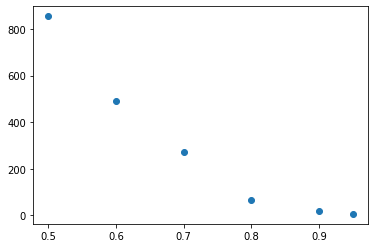

In [19]:
plt.scatter(*zip(*plot_values))

In [20]:
thresholds[0][1]

[('Started Daily Cleanup of Temporary Directories.',
  'Starting Cleanup of Temporary Directories...'),
 ('Started Daily Cleanup of Temporary Directories.',
  'Started Cleanup of Temporary Directories.'),
 ('Starting Create Volatile Files and Directories...',
  'Started Create Volatile Files and Directories.'),
 ('Starting Update UTMP about System Boot/Shutdown...',
  'Started Update UTMP about System Boot/Shutdown.'),
 ('Starting udev Coldplug all Devices...',
  'Started udev Coldplug all Devices.'),
 ('Stopped Virtual filesystem service.',
  'Starting Virtual filesystem service...'),
 ('Stopped Virtual filesystem service.',
  'Stopping Virtual filesystem service...'),
 ('Stopped Virtual filesystem service.',
  'Started Virtual filesystem service.'),
 ("Successfully activated service 'org.gtk.vfs.UDisks2VolumeMonitor'",
  "Successfully activated service 'org.gtk.vfs.GoaVolumeMonitor'"),
 ("Successfully activated service 'org.gtk.vfs.UDisks2VolumeMonitor'",
  "Successfully activated se

In [21]:
uq_f_pairs = []

for mm in range(5):

    lst1 = list(zip(*thresholds[mm][1]))[0]
    lst2 = list(zip(*thresholds[mm][1]))[1]
    unq_elmts = list(set(lst1 + lst2))

    uq_f_pairs.append((mm,len(unq_elmts)))

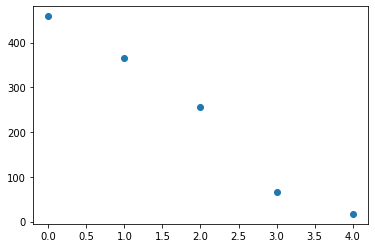

In [22]:
plt.scatter(*zip(*uq_f_pairs))

In [23]:
l = thresholds[3][1]

def get_clusters(lst):

    result = []
    if len(l) > 1:
        tmp = [l[0]]
        for i in range(1,len(l)):
            if l[i][0] == l[i-1][1] or l[i][1] == l[i-1][0] or l[i][1] == l[i-1][1] or l[i][0] == l[i-1][0]:
                tmp.append(l[i])
            else:
                result.append(tmp)
                tmp = [l[i]]
        result.append(tmp)
    else:
        result = l

    return result

In [24]:
result = get_clusters(l)

#for elem in result:
#    print(elem)


In [25]:
print("individual clusters: {}".format(len(result)))

individual clusters: 40


In [26]:
import operator

centroids = []

for elem in result:
    b = Counter([i for sub in elem for i in sub])
    mx = max(b.items(), key=operator.itemgetter(1))[0]
    print(mx)
    centroids.append(mx)

checking bus 1, device 5: "/sys/devices/platform/soc/3f980000.usb/usb1/1-1/1-1.1/1-1.1.2"
[origin software="rsyslogd" swVersion="8.24.0" x-pid="324" x-info="http://www.rsyslog.com"] start
Joining mDNS multicast group on interface wlan0.IPv6 with address fe80::1013:35ee:ab9d:d76b.
EXT4-fs (mmcblk0p5): mounted filesystem with ordered data mode. Opts: (null)
usb 1-1.2: New USB device strings: Mfr=1, Product=2, SerialNumber=0
Stopped User Manager for UID 1002.
usbcore: registered new interface driver usbfs
Server startup complete. Host name is raspberrypi.local. Local service cookie is 929520076.
Memory: 886308K/917504K available (8192K kernel code, 629K rwdata, 2176K rodata, 1024K init, 821K bss, 23004K reserved, 8192K cma-reserved)
mmc-bcm2835 3f300000.mmc: could not get clk, deferring probe
Successfully activated service 'org.freedesktop.systemd1'
Mountpoint-cache hash table entries: 2048 (order: 1, 8192 bytes)
(root) CMD (test -x /usr/sbin/anacron || ( cd / && run-parts --report /etc/c

In [27]:
len(centroids)

40